# Cancer Cell Lines Enriched Loci: DE Analysis
The goal in this notebook is to identify smRNA loci that are enriched in cancerous cell lines and not in normal cell lines via DESeq based analysis. In this notebook we compare all the cancer cell lines vs normal cell lines.

In [1]:
import pandas as pd
import json as js
import warnings
warnings.filterwarnings("ignore")
import rpy2.ipython
%load_ext rpy2.ipython

In [2]:
%%R 
library(DESeq2)
library(EnhancedVolcano)

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int

## Load Counts

In [3]:
with open('data/counts/cell_lines_loci_counts.json', 'r') as f:
    sample_loci = js.load(f)
    f.close()

In [4]:
#Unique loci after healthy exRNA filtering
unique_loci = set()
for cell_line, loci_dict in sample_loci.items():
    unique_loci.update(loci_dict.keys())
len(unique_loci)

1569283

In [5]:
# Filter out LM2_2_cell_S37 from consideration
del sample_loci["LM2_2_cell_S37"]

## DESeq Analysis
Here we run DESeq Analysis conditioned on cancer/non-cancer

In [6]:
cell_lines = list(sample_loci.keys())
condition = ["Normal" if "HUMEC" in name else "Cancer" for name in cell_lines ]
samples = [name.split("_")[-1] for name in cell_lines] #Extract just the sample number

In [7]:
coldata = pd.DataFrame({"condition":condition, 
                        "type":["single_read"]*len(condition),
                        "name":cell_lines})
coldata.index=samples
coldata = coldata.sort_index()
coldata

,condition,type,name
S24,Normal,single_read,HUMEC_1_cell_S24
S25,Cancer,single_read,MDA231_1_cell_S25
S26,Cancer,single_read,LM2_1_cell_S26
S27,Cancer,single_read,CN34_1_cell_S27
S28,Cancer,single_read,LM1a_1_cell_S28
S29,Cancer,single_read,HCC38_1_cell_S29
S31,Cancer,single_read,MDA453_1_cell_S31
S32,Cancer,single_read,MCF7_1_cell_S32
S33,Cancer,single_read,SKBR-3_1_cell_S33
S34,Cancer,single_read,ZR75-1_1_cell_S34


### Create Loci Count Matrix

In [8]:
#Create 
loci_counts = {} #Use the raw counts
for locus in unique_loci:
    loci_counts[locus] = {} 
    for cell_line, loci_dict in sample_loci.items():
        if locus in loci_dict:
            loci_counts[locus][cell_line] = loci_dict[locus]
        else:
            loci_counts[locus][cell_line] = 0

In [9]:
col_name_map = {}
for name in cell_lines:
    col_name_map[name] = name.split("_")[-1]

In [10]:
cm = pd.DataFrame(loci_counts).T
cm = cm.rename(columns=col_name_map)
cm = cm.sort_index(axis=1) #To match coldata
cm.head()

,S24,S25,S26,S27,S28,S29,S31,S32,S33,S34,S35,S36,S38,S39,S40,S42,S43,S44,S45,S46
chr4:766432-766472:+,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chr19:38466252-38466267:-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
chr7:121874258-121874276:-,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
chr17:16851724-16851741:-,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
chr6:121274403-121274418:+,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [11]:
%%R -i coldata,cm
dds <- DESeqDataSetFromMatrix(countData = cm, colData = coldata, design = ~ condition)
dds <- DESeq(dds)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 154 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [13]:
%%R -o dds_res
dds_res <- as.data.frame(results(dds, contrast=c("condition", "Cancer", "Normal"), tidy=TRUE))
dds_res <- dds_res[!is.na(dds_res$padj),]

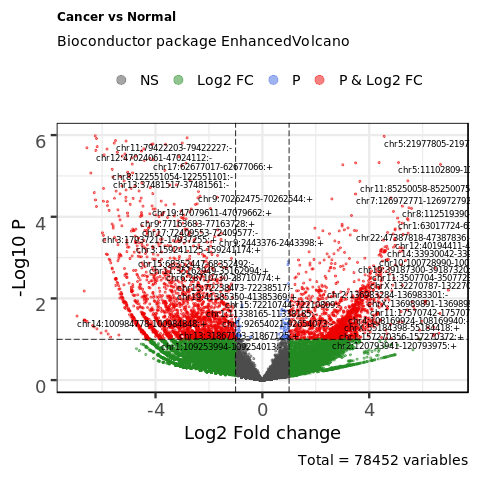

In [14]:
%%R
pdf('figures/cancer_enriched_loci_DE.pdf')

p <- EnhancedVolcano(dds_res, lab = dds_res$row, x= "log2FoldChange", xlab="Log2 Fold change",
                          y="pvalue", ylab="-Log10 P", title= "Cancer vs Normal",
                          titleLabSize = 12, border = "full", pCutoff = 0.1, FCcutoff=1, xlim = c(-7,7),
                          ylim=c(0,6))
print(p)
dev.off()
p

In [15]:
sig_res = dds_res[(dds_res["pvalue"] <= 0.1) & (dds_res["log2FoldChange"] >= 1)]
sig_res = sig_res.set_index("row", drop=False)
print(sig_res.shape)
sig_res.head()

(1636, 7)


,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
row,,,,,,,
chr2:120793941-120793975:+,chr2:120793941-120793975:+,7.218073,2.602324,1.563306,1.664629,0.095987,0.997586
chr5:133519904-133519922:+,chr5:133519904-133519922:+,1.104110,2.808618,1.577755,1.780136,0.075054,0.997586
chr4:15883710-15883726:+,chr4:15883710-15883726:+,0.967210,2.652188,1.575876,1.682993,0.092377,0.997586
chrX:55184398-55184418:+,chrX:55184398-55184418:+,1.319271,3.058652,1.448228,2.111996,0.034687,0.997586
chr2:108825431-108825448:-,chr2:108825431-108825448:-,1.289241,2.994811,1.420320,2.108546,0.034984,0.997586


## HUMEC Filter

In [16]:
humec_loci = set()
for cell_line, loci_dict in sample_loci.items():
    if "HUMEC" in cell_line:
        humec_loci.update(loci_dict.keys())
len(humec_loci)

408011

In [17]:
humec_fil_sig_loci = set()
for locus in sig_res["row"]:
    if locus not in humec_loci:
        humec_fil_sig_loci.add(locus)
len(humec_fil_sig_loci)

812

With a more laxed pvalue cutoff, we get around 812 considered significant loci to work with. Let's save these loci and merge with our Fisher results for downstream analysis.

## Save Results

In [18]:
with open("results/DESeq/cell_lines_sig_loci_deseq.bed", "wt") as out:   
    for locus in humec_fil_sig_loci:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")

In [19]:
dds_res.to_csv("results/DESeq/dds_res.csv")

# Done